# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [431]:
# student 1:9940 Alan


## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier


In [433]:
train_set  = pd.read_csv(r".\titanic_train.csv")
test_set = pd.read_csv(r".\titanic_test.csv")

In [434]:
train_set.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [435]:
test_set.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


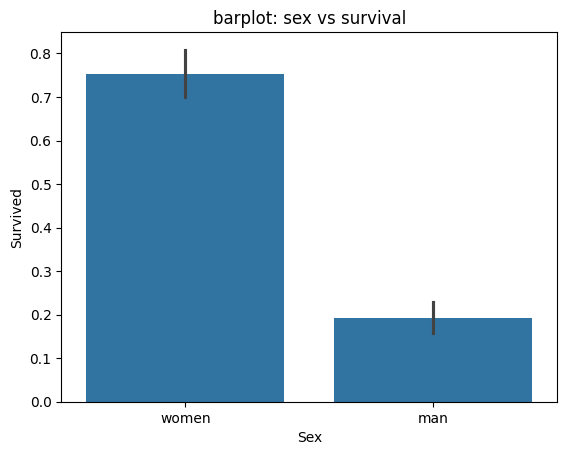

In [436]:
train_set_rename = train_set.copy()
train_set_rename['Sex'] = train_set_rename['Sex'].map({0: 'women', 1: 'man'})

sns.barplot(x='Sex', y='Survived', data=train_set_rename)
plt.title('barplot: sex vs survival')

plt.show()

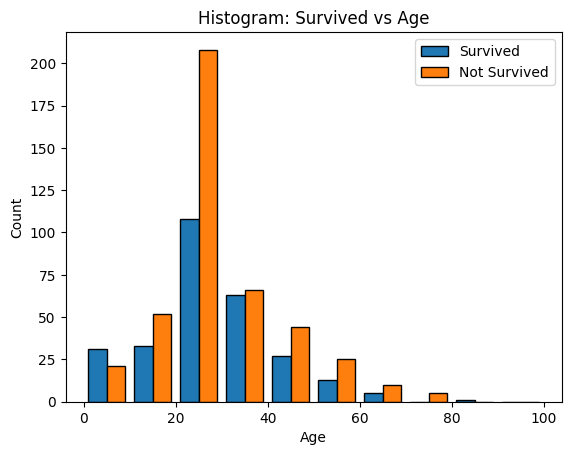

In [437]:
survived = train_set[train_set['Survived'] == 1]['Age'].dropna()
not_survived = train_set[train_set['Survived'] == 0]['Age'].dropna()

plt.hist([survived, not_survived], bins=10, range=(0, 100), label=['Survived', 'Not Survived'], edgecolor='black')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram: Survived vs Age')
plt.legend()

plt.show()

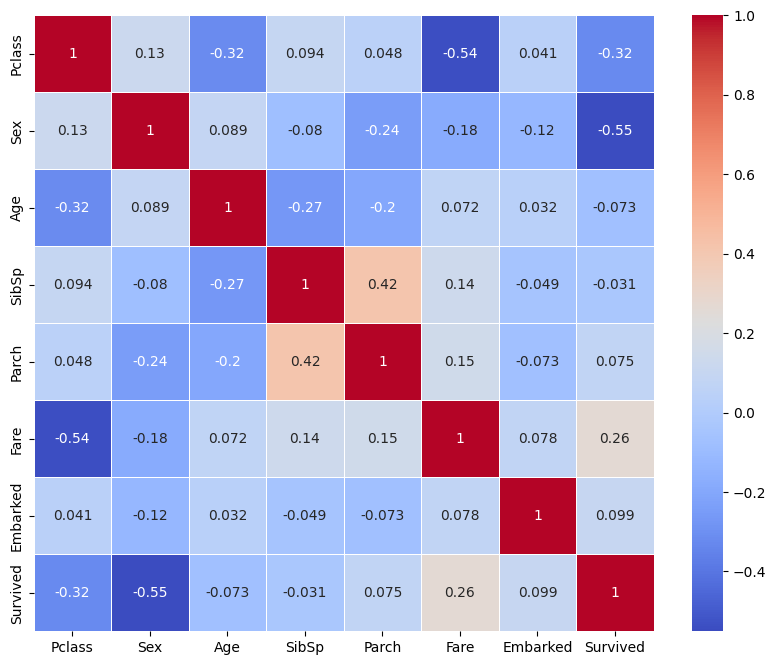

In [438]:
correlation_matrix = train_set.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.show()

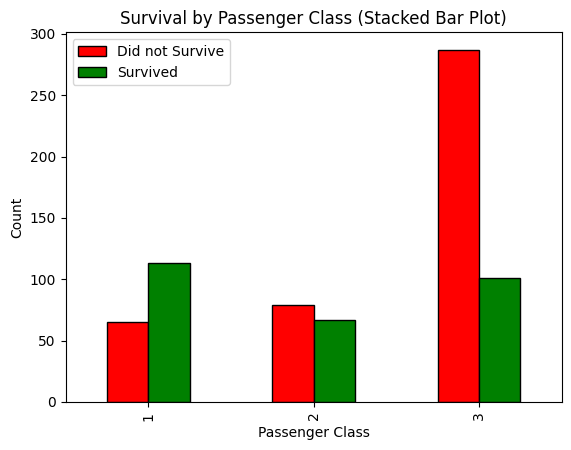

In [439]:
survived_counts = train_set.groupby(['Pclass', 'Survived']).size().unstack()

# Plot a stacked bar plot
survived_counts.plot(kind='bar', color=['red', 'green'], edgecolor='black')

# Add labels and title
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.title('Survival by Passenger Class (Stacked Bar Plot)')
plt.legend(['Did not Survive', 'Survived'])

# Show the plot
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [440]:

# Define feature columns
numeric_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Define target variable
X = train_set[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = train_set['Survived']

# Preprocessing pipeline: Scale numeric features and encode categorical features
# This step is part of Feature Engineering
preprocessor = ColumnTransformer(
    transformers=[
        # Feature Engineering: Scaling numeric features to standardize their range
        ('num', StandardScaler(), numeric_features),
        # Feature Engineering: Encoding categorical features using one-hot encoding
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Feature Engineering with PCA
pca = PCA(n_components=2)

# Algorithms: KNN, Decision Tree, and Random Forest
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

# Define hyperparameters for KNN: 3 values of k (sqrt of N), distance metrics
param_grid_knn = {
    'model__n_neighbors': [25, 26, 27],  # Square root of N approximation
    'model__metric': ['euclidean', 'manhattan', 'chebyshev']  # Distance metrics
}

# Define hyperparameters for Decision Tree: depth 2-7 and criterion=entropy
param_grid_tree = {
    'model__max_depth': [2, 3, 4, 5, 6, 7],
    'model__criterion': ['entropy']  # Entropy for splitting criterion
}

# Define hyperparameters for Random Forest: number of trees and max depth
param_grid_forest = {
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [4, 5, 6, 7]  # Maximum depth of the tree
}

# Scoring function
scorer = make_scorer(f1_score, average='macro')

# Pipelines for all algorithms: KNN, Decision Tree, Random Forest (with and without PCA)
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca), ('model', knn)])
pipeline_tree = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca), ('model', decision_tree)])
pipeline_forest = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca), ('model', random_forest)])

# Without PCA
pipeline_knn_no_pca = Pipeline(steps=[('preprocessor', preprocessor), ('model', knn)])
pipeline_tree_no_pca = Pipeline(steps=[('preprocessor', preprocessor), ('model', decision_tree)])
pipeline_forest_no_pca = Pipeline(steps=[('preprocessor', preprocessor), ('model', random_forest)])

# Grid search with 5-fold cross-validation for all models
grid_search_knn_with_pca = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring=scorer)
grid_search_knn_no_pca = GridSearchCV(pipeline_knn_no_pca, param_grid_knn, cv=5, scoring=scorer)

grid_search_tree_with_pca = GridSearchCV(pipeline_tree, param_grid_tree, cv=5, scoring=scorer)
grid_search_tree_no_pca = GridSearchCV(pipeline_tree_no_pca, param_grid_tree, cv=5, scoring=scorer)

grid_search_forest_with_pca = GridSearchCV(pipeline_forest, param_grid_forest, cv=5, scoring=scorer)
grid_search_forest_no_pca = GridSearchCV(pipeline_forest_no_pca, param_grid_forest, cv=5, scoring=scorer)

# Fit the models (KNN, Decision Tree, and Random Forest) with and without PCA
grid_search_knn_with_pca.fit(X, y)
grid_search_knn_no_pca.fit(X, y)

grid_search_tree_with_pca.fit(X, y)
grid_search_tree_no_pca.fit(X, y)

grid_search_forest_with_pca.fit(X, y)
grid_search_forest_no_pca.fit(X, y)

# Collecting the results
results = {
    'KNN with PCA': grid_search_knn_with_pca.best_score_,
    'KNN without PCA': grid_search_knn_no_pca.best_score_,
    'Decision Tree with PCA': grid_search_tree_with_pca.best_score_,
    'Decision Tree without PCA': grid_search_tree_no_pca.best_score_,
    'Random Forest with PCA': grid_search_forest_with_pca.best_score_,
    'Random Forest without PCA': grid_search_forest_no_pca.best_score_
}

# Display results
print("Best F1 scores from the Grid Search with 5-Fold Cross-Validation:")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

#  display the best parameters for each model
print("\nBest Hyperparameters:")
print("KNN with PCA:", grid_search_knn_with_pca.best_params_)
print("KNN without PCA:", grid_search_knn_no_pca.best_params_)
print("Decision Tree with PCA:", grid_search_tree_with_pca.best_params_)
print("Decision Tree without PCA:", grid_search_tree_no_pca.best_params_)
print("Random Forest with PCA:", grid_search_forest_with_pca.best_params_)
print("Random Forest without PCA:", grid_search_forest_no_pca.best_params_)



Best F1 scores from the Grid Search with 5-Fold Cross-Validation:
KNN with PCA: 0.7144
KNN without PCA: 0.7694
Decision Tree with PCA: 0.6976
Decision Tree without PCA: 0.7876
Random Forest with PCA: 0.7184
Random Forest without PCA: 0.8090

Best Hyperparameters:
KNN with PCA: {'model__metric': 'euclidean', 'model__n_neighbors': 27}
KNN without PCA: {'model__metric': 'euclidean', 'model__n_neighbors': 25}
Decision Tree with PCA: {'model__criterion': 'entropy', 'model__max_depth': 6}
Decision Tree without PCA: {'model__criterion': 'entropy', 'model__max_depth': 3}
Random Forest with PCA: {'model__max_depth': 7, 'model__n_estimators': 200}
Random Forest without PCA: {'model__max_depth': 7, 'model__n_estimators': 100}


In [441]:
comparison_data = {
    'Model': [
        'KNN with PCA', 'KNN without PCA', 
        'Decision Tree with PCA', 'Decision Tree without PCA',
        'Random Forest with PCA', 'Random Forest without PCA'
    ],
    'Best F1 Score': [
        grid_search_knn_with_pca.best_score_,
        grid_search_knn_no_pca.best_score_,
        grid_search_tree_with_pca.best_score_,
        grid_search_tree_no_pca.best_score_,
        grid_search_forest_with_pca.best_score_,
        grid_search_forest_no_pca.best_score_
    ],
    'Best Parameters': [
        grid_search_knn_with_pca.best_params_,
        grid_search_knn_no_pca.best_params_,
        grid_search_tree_with_pca.best_params_,
        grid_search_tree_no_pca.best_params_,
        grid_search_forest_with_pca.best_params_,
        grid_search_forest_no_pca.best_params_
    ]
}

# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison DataFrame
print(comparison_df)

                       Model  Best F1 Score  \
0               KNN with PCA       0.714394   
1            KNN without PCA       0.769382   
2     Decision Tree with PCA       0.697594   
3  Decision Tree without PCA       0.787630   
4     Random Forest with PCA       0.718370   
5  Random Forest without PCA       0.809044   

                                            Best Parameters  
0  {'model__metric': 'euclidean', 'model__n_neighbors': 27}  
1  {'model__metric': 'euclidean', 'model__n_neighbors': 25}  
2    {'model__criterion': 'entropy', 'model__max_depth': 6}  
3    {'model__criterion': 'entropy', 'model__max_depth': 3}  
4       {'model__max_depth': 7, 'model__n_estimators': 200}  
5       {'model__max_depth': 7, 'model__n_estimators': 100}  


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [442]:
# Retrain the best model from grid search
best_model = grid_search_forest_no_pca.best_estimator_

# Fit the model on the training data
best_model.fit(train_set.drop(columns='Survived'), train_set['Survived'])

# Predictions on the train data
train_predictions = best_model.predict(train_set.drop(columns='Survived'))

# Calculate F1 Score on train data
f1_train = f1_score(train_set['Survived'], train_predictions)
print(f"F1 Score on train data (Best Model): {f1_train:.4f}")





F1 Score on train data (Best Model): 0.8494


## Part 5 - Apply on test and show model performance estimation

In [443]:
# Predictions on the test data
test_predictions = best_model.predict(test_set.drop(columns='Survived'))

# Create a copy of the test set to include predictions
test_set_with_predictions = test_set.copy()
test_set_with_predictions['Predicted_Survived'] = test_predictions

# Display the first 5 rows of the test set with the predicted 'Survived' column
print(test_set_with_predictions.head(5))

# Calculate the F1 score for the test set
f1_test = f1_score(test_set['Survived'], test_predictions, average='macro')
print(f"F1 Score on test data (Best Model): {f1_test:.4f}")

   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived  \
0       3    1  35.000000      0      0   7.0500         0         0   
1       3    1  30.000000      0      0   7.2500         0         0   
2       3    1  29.699118      0      0  14.5000         0         0   
3       3    0  21.000000      0      0   7.7500         2         0   
4       3    1  32.000000      0      0  56.4958         0         1   

   Predicted_Survived  
0                   0  
1                   0  
2                   0  
3                   1  
4                   0  
F1 Score on test data (Best Model): 0.8456
